In [0]:
#这个文件是用strength来预测distribute的  用flipped 和 nonflipped数据来跑模型
# !pip install import-ipynb
# import import_ipynb

# %tensorflow_version 1.x

TensorFlow 1.x selected.


In [29]:

import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt 
from keras.models import Model, Sequential 
from keras.layers import Conv1D,Flatten,Conv2D, Dropout, MaxPooling2D, Input,Conv3D, MaxPooling3D, Dense, BatchNormalization
from keras.layers.merge import concatenate 
from keras.layers import Flatten 
from google.colab import drive
from keras import Input,layers
from keras.layers import Conv2D
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier,KerasRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
drive.mount('/content/drive')
# %cp -av fromfolder tofolder
# %cd "/content/drive/My Drive/Newdata/"
# from model_functions import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
a = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8] 
a = np.array(a)
b = tf.where(a>0.5,1.0,0)
print(b)

tf.Tensor([0. 0. 0. 0. 0. 0. 1. 1. 1.], shape=(9,), dtype=float32)


# nonflipped全保留数据 不带control  2 labels

In [0]:
#将 24 个 150,30,116 穿连到一起 变成3600,30,116   数据较小  不需要保存
# num = np.load('/content/drive/My Drive/strength/nonflipped/all/1.npy')
# num = np.reshape(num,(150,30,116))
# for i in range(2,25):
#   Num = np.load('/content/drive/My Drive/strength/nonflipped/all/' + str(i) + '.npy')
#   Num = np.reshape(Num,(150,30,116)) 
#   num = np.concatenate((num,Num),axis = 0)

# print(num.shape)   #(3600, 30, 116)

(3600, 30, 116)


In [2]:
patient_order = range(1,25)
order = shuffle(patient_order, random_state = 10)
print(patient_order)
print(order)  
# [14, 18, 20, 5, 2, 22, 19, 15, 23, 17, 24, 13, 11, 6, 9, 7, 1, 3, 8, 12, 21, 10, 16, 4]    random_state =20 
# [6, 2, 8, 3, 12, 13, 22, 14, 15, 4, 23, 7, 19, 11, 21, 24, 9, 20, 17, 18, 1, 16, 5, 10]    random_state =10

tmp = order[0]
A = np.load('/content/drive/My Drive/strength/nonflipped/all/three/' + str(tmp)+ '.npy')
A = np.reshape(A,(150,30,116))
for i in order[1:18]: 
  a = np.load('/content/drive/My Drive/strength/nonflipped/all/three/' + str(i)+ '.npy')
  a = np.reshape(a,(150,30,116))
  A = np.concatenate((A,a), axis = 0)
print(A.shape)
# 前十八个 病人数据做训练data(2700, 30, 116)


tmp = order[0]
B = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/two_labels/' + str(tmp)+ '.npy')
for i in order[1:18]: 
  b = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/two_labels/' + str(i)+ '.npy')
  B = np.concatenate((B,b), axis = 0)
print(B.shape)
# 前十八个 病人数据做训练label(2700, 2)

tmp = order[18]
C = np.load('/content/drive/My Drive/strength/nonflipped/all/three/' + str(tmp)+ '.npy')
C = np.reshape(C,(150,30,116))
for i in order[19:]: 
  c = np.load('/content/drive/My Drive/strength/nonflipped/all/three/' + str(i)+ '.npy')
  c = np.reshape(c,(150,30,116))
  C = np.concatenate((C,c), axis = 0)
print(C.shape)
# 后六个人 病人数据做测试data(900, 30, 116)

tmp = order[18]
D = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/two_labels/' + str(tmp)+ '.npy')
for i in order[19:]: 
  d = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/two_labels/' + str(i)+ '.npy')
  D = np.concatenate((D,d), axis = 0)
print(D.shape)
# 后六个人 病人数据做测试label(900, 2)

# np.save('/content/drive/My Drive/Newdata/ordered_by_patient/train_data_2700_6_116_116_original', A)
# np.save('/content/drive/My Drive/Newdata/ordered_by_patient/train_label_2700_25_3', B)
# np.save('/content/drive/My Drive/Newdata/ordered_by_patient/test_data_900_6_116_116_original', C)
# np.save('/content/drive/My Drive/Newdata/ordered_by_patient/test_label_900_25_3', D)

range(1, 25)
[6, 2, 8, 3, 12, 13, 22, 14, 15, 4, 23, 7, 19, 11, 21, 24, 9, 20, 17, 18, 1, 16, 5, 10]
(2700, 30, 116)
(2700, 2)
(900, 30, 116)
(900, 2)


In [3]:
train_data = A
train_label = B
test_data = C
test_label = D

# train_data = np.reshape(train_data,(2700,30,116,1))
# test_data = np.reshape(test_data,(900,30,116,1)) 

print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)
print(train_data[:,0].shape)

(2700, 30, 116)
(2700, 2)
(900, 30, 116)
(900, 2)
(2700, 116)


In [0]:
#He正态分布初始化方法，参数由0均值，标准差为sqrt(2 / fan_in) 的正态分布产生，其中fan_in权重张量的扇入
def Functional_model():  
   # This returns a tensor# a layer instance is callable on a tensor, and returns a tensor
  input1 = Input(shape=(116,))
  input2 = Input(shape=(116,))
  input3 = Input(shape=(116,))
  input4 = Input(shape=(116,))
  input5 = Input(shape=(116,))
  input6 = Input(shape=(116,))
  input7 = Input(shape=(116,))
  input8 = Input(shape=(116,))
  input9 = Input(shape=(116,))
  input10 = Input(shape=(116,))
  input11 = Input(shape=(116,))
  input12 = Input(shape=(116,))
  input13 = Input(shape=(116,))
  input14 = Input(shape=(116,))
  input15 = Input(shape=(116,))
  input16 = Input(shape=(116,))
  input17 = Input(shape=(116,))
  input18 = Input(shape=(116,))
  input19 = Input(shape=(116,))
  input20 = Input(shape=(116,))
  input21 = Input(shape=(116,))
  input22 = Input(shape=(116,))
  input23 = Input(shape=(116,))
  input24 = Input(shape=(116,))
  input25 = Input(shape=(116,))
  input26 = Input(shape=(116,))
  input27 = Input(shape=(116,))
  input28 = Input(shape=(116,))
  input29 = Input(shape=(116,))
  input30 = Input(shape=(116,))

  x1 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(input1)
  x1 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x1)  
  x1 = layers.Dense(512, activation='relu', kernel_initializer='lecun_uniform')(x1) 
  x1 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x1)  
  x1 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(x1)     
  x1 = layers.Dense(64, activation='relu', kernel_initializer='lecun_uniform')(x1)  
  y1 = layers.Dense(32, activation='relu', kernel_initializer='lecun_uniform')(x1)
  y1 = Model(inputs=input1, outputs=y1)

  x2 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(input2) 
  x2 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x2)  
  x2 = layers.Dense(512, activation='relu', kernel_initializer='lecun_uniform')(x2) 
  x2 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x2)  
  x2 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(x2)
  x2 = layers.Dense(64, activation='relu', kernel_initializer='lecun_uniform')(x2)  
  y2 = layers.Dense(32, activation='relu', kernel_initializer='lecun_uniform')(x2)
  y2 = Model(inputs=input2, outputs=y2)

  x3 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(input3) 
  x3 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x3)  
  x3 = layers.Dense(512, activation='relu', kernel_initializer='lecun_uniform')(x3) 
  x3 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x3)  
  x3 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(x3)
  x3 = layers.Dense(64, activation='relu', kernel_initializer='lecun_uniform')(x3)  
  y3 = layers.Dense(32, activation='relu', kernel_initializer='lecun_uniform')(x3)
  y3 = Model(inputs=input3, outputs=y3)

  x4 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(input4) 
  x4 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x4)  
  x4 = layers.Dense(512, activation='relu', kernel_initializer='lecun_uniform')(x4) 
  x4 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x4)  
  x4 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(x4)
  x4 = layers.Dense(64, activation='relu', kernel_initializer='lecun_uniform')(x4)  
  y4 = layers.Dense(32, activation='relu', kernel_initializer='lecun_uniform')(x4)
  y4 = Model(inputs=input4, outputs=y4)

  x5 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(input5) 
  x5 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x5)  
  x5 = layers.Dense(512, activation='relu', kernel_initializer='lecun_uniform')(x5) 
  x5 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x5)  
  x5 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(x5)
  x5 = layers.Dense(64, activation='relu', kernel_initializer='lecun_uniform')(x5)  
  y5 = layers.Dense(32, activation='relu', kernel_initializer='lecun_uniform')(x5)
  y5 = Model(inputs=input5, outputs=y5)

  x6 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(input6) 
  x6 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x6)  
  x6 = layers.Dense(512, activation='relu', kernel_initializer='lecun_uniform')(x6) 
  x6 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x6)  
  x6 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(x6)
  x6 = layers.Dense(64, activation='relu', kernel_initializer='lecun_uniform')(x6)  
  y6 = layers.Dense(32, activation='relu', kernel_initializer='lecun_uniform')(x6)
  y6 = Model(inputs=input6, outputs=y6)

  x7 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(input7) 
  x7 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x7)  
  x7 = layers.Dense(512, activation='relu', kernel_initializer='lecun_uniform')(x7) 
  x7 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x7)  
  x7 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(x7)
  x7 = layers.Dense(64, activation='relu', kernel_initializer='lecun_uniform')(x7)  
  y7 = layers.Dense(32, activation='relu', kernel_initializer='lecun_uniform')(x7)
  y7 = Model(inputs=input7, outputs=y7)

  x8 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(input8) 
  x8 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x8)  
  x8 = layers.Dense(512, activation='relu', kernel_initializer='lecun_uniform')(x8) 
  x8 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x8)  
  x8 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(x8)
  x8 = layers.Dense(64, activation='relu', kernel_initializer='lecun_uniform')(x8)  
  y8 = layers.Dense(32, activation='relu', kernel_initializer='lecun_uniform')(x8)
  y8 = Model(inputs=input8, outputs=y8)

  x9 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(input9) 
  x9 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x9)  
  x9 = layers.Dense(512, activation='relu', kernel_initializer='lecun_uniform')(x9) 
  x9 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x9)  
  x9 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(x9)
  x9 = layers.Dense(64, activation='relu', kernel_initializer='lecun_uniform')(x9)  
  y9 = layers.Dense(32, activation='relu', kernel_initializer='lecun_uniform')(x9)
  y9 = Model(inputs=input9, outputs=y9)

  x10 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(input10) 
  x10 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x10)  
  x10 = layers.Dense(512, activation='relu', kernel_initializer='lecun_uniform')(x10) 
  x10 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x10)  
  x10 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(x10)
  x10 = layers.Dense(64, activation='relu', kernel_initializer='lecun_uniform')(x10)  
  y10 = layers.Dense(32, activation='relu', kernel_initializer='lecun_uniform')(x10)
  y10 = Model(inputs=input10, outputs=y10)

  x11 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(input11) 
  x11 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x11)  
  x11 = layers.Dense(512, activation='relu', kernel_initializer='lecun_uniform')(x11) 
  x11 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x11)  
  x11 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(x11)
  x11 = layers.Dense(64, activation='relu', kernel_initializer='lecun_uniform')(x11)  
  y11 = layers.Dense(32, activation='relu', kernel_initializer='lecun_uniform')(x11)
  y11 = Model(inputs=input11, outputs=y11)

  x12 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(input12) 
  x12 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x12)  
  x12 = layers.Dense(512, activation='relu', kernel_initializer='lecun_uniform')(x12) 
  x12 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x12)  
  x12 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(x12)
  x12 = layers.Dense(64, activation='relu', kernel_initializer='lecun_uniform')(x12)  
  y12 = layers.Dense(32, activation='relu', kernel_initializer='lecun_uniform')(x12)
  y12 = Model(inputs=input12, outputs=y12)

  x13 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(input13) 
  x13 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x13)  
  x13 = layers.Dense(512, activation='relu', kernel_initializer='lecun_uniform')(x13) 
  x13 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x13)  
  x13 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(x13)
  x13 = layers.Dense(64, activation='relu', kernel_initializer='lecun_uniform')(x13)  
  y13 = layers.Dense(32, activation='relu', kernel_initializer='lecun_uniform')(x13)
  y13 = Model(inputs=input13, outputs=y13)

  x14 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(input14) 
  x14 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x14)  
  x14 = layers.Dense(512, activation='relu', kernel_initializer='lecun_uniform')(x14) 
  x14 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x14)  
  x14 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(x14)
  x14 = layers.Dense(64, activation='relu', kernel_initializer='lecun_uniform')(x14)  
  y14 = layers.Dense(32, activation='relu', kernel_initializer='lecun_uniform')(x14)
  y14 = Model(inputs=input14, outputs=y14)

  x15 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(input15) 
  x15 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x15)  
  x15 = layers.Dense(512, activation='relu', kernel_initializer='lecun_uniform')(x15) 
  x15 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x15)  
  x15 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(x15)
  x15 = layers.Dense(64, activation='relu', kernel_initializer='lecun_uniform')(x15)  
  y15 = layers.Dense(32, activation='relu', kernel_initializer='lecun_uniform')(x15)
  y15 = Model(inputs=input15, outputs=y15)

  x16 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(input16) 
  x16 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x16)  
  x16 = layers.Dense(512, activation='relu', kernel_initializer='lecun_uniform')(x16) 
  x16 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x16)  
  x16 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(x16)
  x16 = layers.Dense(64, activation='relu', kernel_initializer='lecun_uniform')(x16)  
  y16 = layers.Dense(32, activation='relu', kernel_initializer='lecun_uniform')(x16)
  y16 = Model(inputs=input16, outputs=y16)

  x17 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(input17) 
  x17 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x17)  
  x17 = layers.Dense(512, activation='relu', kernel_initializer='lecun_uniform')(x17) 
  x17 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x17)  
  x17 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(x17)
  x17 = layers.Dense(64, activation='relu', kernel_initializer='lecun_uniform')(x17)  
  y17 = layers.Dense(32, activation='relu', kernel_initializer='lecun_uniform')(x17)
  y17 = Model(inputs=input17, outputs=y17)

  x18 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(input18) 
  x18 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x18)  
  x18 = layers.Dense(512, activation='relu', kernel_initializer='lecun_uniform')(x18) 
  x18 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x18)  
  x18 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(x18)
  x18 = layers.Dense(64, activation='relu', kernel_initializer='lecun_uniform')(x18)  
  y18 = layers.Dense(32, activation='relu', kernel_initializer='lecun_uniform')(x18)
  y18 = Model(inputs=input18, outputs=y18)

  x19 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(input19) 
  x19 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x19)  
  x19 = layers.Dense(512, activation='relu', kernel_initializer='lecun_uniform')(x19) 
  x19 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x19)  
  x19 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(x19)
  x19 = layers.Dense(64, activation='relu', kernel_initializer='lecun_uniform')(x19)  
  y19 = layers.Dense(32, activation='relu', kernel_initializer='lecun_uniform')(x19)
  y19 = Model(inputs=input19, outputs=y19)

  x20 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(input20) 
  x20 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x20)  
  x20 = layers.Dense(512, activation='relu', kernel_initializer='lecun_uniform')(x20) 
  x20 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x20)  
  x20 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(x20)
  x20 = layers.Dense(64, activation='relu', kernel_initializer='lecun_uniform')(x20)  
  y20 = layers.Dense(32, activation='relu', kernel_initializer='lecun_uniform')(x20)
  y20 = Model(inputs=input20, outputs=y20)

  x21 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(input21)
  x21 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x21)  
  x21 = layers.Dense(512, activation='relu', kernel_initializer='lecun_uniform')(x21) 
  x21 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x21)  
  x21 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(x21) 
  x21 = layers.Dense(64, activation='relu', kernel_initializer='lecun_uniform')(x21)  
  y21 = layers.Dense(32, activation='relu', kernel_initializer='lecun_uniform')(x21)
  y21 = Model(inputs=input21, outputs=y21)

  x22 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(input22) 
  x22 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x22)  
  x22 = layers.Dense(512, activation='relu', kernel_initializer='lecun_uniform')(x22) 
  x22 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x22)  
  x22 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(x22)
  x22 = layers.Dense(64, activation='relu', kernel_initializer='lecun_uniform')(x22)  
  y22 = layers.Dense(32, activation='relu', kernel_initializer='lecun_uniform')(x22)
  y22 = Model(inputs=input22, outputs=y22)

  x23 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(input23) 
  x23 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x23)  
  x23 = layers.Dense(512, activation='relu', kernel_initializer='lecun_uniform')(x23) 
  x23 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x23)  
  x23 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(x23)
  x23 = layers.Dense(64, activation='relu', kernel_initializer='lecun_uniform')(x23)  
  y23 = layers.Dense(32, activation='relu', kernel_initializer='lecun_uniform')(x23)
  y23 = Model(inputs=input23, outputs=y23)

  x24 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(input24) 
  x24 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x24)  
  x24 = layers.Dense(512, activation='relu', kernel_initializer='lecun_uniform')(x24) 
  x24 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x24)  
  x24 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(x24)
  x24 = layers.Dense(64, activation='relu', kernel_initializer='lecun_uniform')(x24)  
  y24 = layers.Dense(32, activation='relu', kernel_initializer='lecun_uniform')(x24)
  y24 = Model(inputs=input24, outputs=y24)

  x25 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(input25) 
  x25 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x25)  
  x25 = layers.Dense(512, activation='relu', kernel_initializer='lecun_uniform')(x25) 
  x25 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x25)  
  x25 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(x25)
  x25 = layers.Dense(64, activation='relu', kernel_initializer='lecun_uniform')(x25)  
  y25 = layers.Dense(32, activation='relu', kernel_initializer='lecun_uniform')(x25)
  y25 = Model(inputs=input25, outputs=y25)

  x26 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(input26) 
  x26 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x26)  
  x26 = layers.Dense(512, activation='relu', kernel_initializer='lecun_uniform')(x26) 
  x26 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x26)  
  x26 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(x26)
  x26 = layers.Dense(64, activation='relu', kernel_initializer='lecun_uniform')(x26)  
  y26 = layers.Dense(32, activation='relu', kernel_initializer='lecun_uniform')(x26)
  y26 = Model(inputs=input26, outputs=y26)

  x27 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(input27) 
  x27 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x27)  
  x27 = layers.Dense(512, activation='relu', kernel_initializer='lecun_uniform')(x27) 
  x27 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x27)  
  x27 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(x27)
  x27 = layers.Dense(64, activation='relu', kernel_initializer='lecun_uniform')(x27)  
  y27 = layers.Dense(32, activation='relu', kernel_initializer='lecun_uniform')(x27)
  y27 = Model(inputs=input27, outputs=y27)

  x28 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(input28) 
  x28 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x28)  
  x28 = layers.Dense(512, activation='relu', kernel_initializer='lecun_uniform')(x28) 
  x28 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x28)  
  x28 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(x28)
  x28 = layers.Dense(64, activation='relu', kernel_initializer='lecun_uniform')(x28)  
  y28 = layers.Dense(32, activation='relu', kernel_initializer='lecun_uniform')(x28)
  y28 = Model(inputs=input28, outputs=y28)

  x29 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(input29) 
  x29 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x29)  
  x29 = layers.Dense(512, activation='relu', kernel_initializer='lecun_uniform')(x29) 
  x29 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x29)  
  x29 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(x29)
  x29 = layers.Dense(64, activation='relu', kernel_initializer='lecun_uniform')(x29)  
  y29 = layers.Dense(32, activation='relu', kernel_initializer='lecun_uniform')(x29)
  y29 = Model(inputs=input29, outputs=y29)

  x30 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(input30) 
  x30 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x30)  
  x30 = layers.Dense(512, activation='relu', kernel_initializer='lecun_uniform')(x30) 
  x30 = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x30)  
  x30 = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(x30)
  x30 = layers.Dense(64, activation='relu', kernel_initializer='lecun_uniform')(x30)  
  y30 = layers.Dense(32, activation='relu', kernel_initializer='lecun_uniform')(x30)
  y30 = Model(inputs=input30, outputs=y30)


  # merged = concatenate([y1,y1,y3,y4,y5,y6,y7,y8,y9,y10,
  #                       y11,y12,y13,y14,y15,y16,y17,y18,y19,y20,
  #                       y21,y22,y23,y24,y25,y26,y27,y28,y29,y30])
  
  merged = concatenate([y1.output,y2.output,y3.output,y4.output,y5.output,
                        y6.output,y7.output,y8.output,y9.output,y10.output,
                        y11.output,y12.output,y13.output,y14.output,y15.output,
                        y16.output,y17.output,y18.output,y19.output,y20.output,
                        y21.output,y22.output,y23.output,y24.output,y25.output,
                        y26.output,y27.output,y28.output,y29.output,y30.output])
  
  Y = layers.Dense(1024,activation='relu')(merged)
  Y = layers.Dense(512,activation='relu')(Y)
  Y = layers.Dense(256,activation='relu')(Y)
  Y = layers.Dense(128,activation='relu')(Y)
  Y = layers.Dense(2,activation = 'sigmoid')(Y)

  

  # This creates a model that includes
  # model = Model(inputs=x_input, outputs=[y1,y2,y3,y4
  #                                       #  ,y5,y6,y7,y8,y9,y10,y11,y12,y13,y14,y15,y16
  #                                       #  ,y17,y18,y19,y20,y21,y22,y23,y24,y25
  #                                        ])
  
  # model = Model(inputs=[input1,input2,input3,input4,input5,input6,input7,input8,input9,input10,
  #                       input11,input12,input13,input14,input15,input16,input17,input18,input19,input20,
  #                       input21,input22,input23,input24,input25,input26,input27,input28,input29,input30], outputs=Y)

  model = Model(inputs=[y1.input,y2.input,y3.input,y4.input,y5.input,y6.input,y7.input,y8.input,y9.input,y10.input,
                        y11.input,y12.input,y13.input,y14.input,y15.input,y16.input,y17.input,y18.input,y19.input,y20.input,
                        y21.input,y22.input,y23.input,y24.input,y25.input,y26.input,y27.input,y28.input,y29.input,y30.input],
                 outputs=Y)
  
  model.summary() 
  # model.compile(optimizer = Adam(lr=0.0003),
  #               loss=['binary_crossentropy'],
  #               metrics=['accuracy'])
  model.compile(optimizer = Adam(lr=0.00001),
                  loss = 'mean_squared_error',
                metrics = ['mae'])

  return model 

In [26]:
num_epochs = 500
batchsize = 50
model = Functional_model()
history = model.fit([train_data[:,0],train_data[:,1],train_data[:,2],train_data[:,3],train_data[:,4],
                     train_data[:,5],train_data[:,6],train_data[:,7],train_data[:,8],train_data[:,9],
                     train_data[:,10],train_data[:,11],train_data[:,12],train_data[:,13],train_data[:,14],
                     train_data[:,15],train_data[:,16],train_data[:,17],train_data[:,18],train_data[:,19],
                     train_data[:,20],train_data[:,21],train_data[:,22],train_data[:,23],train_data[:,24],
                     train_data[:,25],train_data[:,26],train_data[:,27],train_data[:,28],train_data[:,29]],
                     train_label, epochs=num_epochs, batch_size=batchsize, verbose=1)


Model: "model_216"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_181 (InputLayer)          (None, 116)          0                                            
__________________________________________________________________________________________________
input_182 (InputLayer)          (None, 116)          0                                            
__________________________________________________________________________________________________
input_183 (InputLayer)          (None, 116)          0                                            
__________________________________________________________________________________________________
input_184 (InputLayer)          (None, 116)          0                                            
__________________________________________________________________________________________

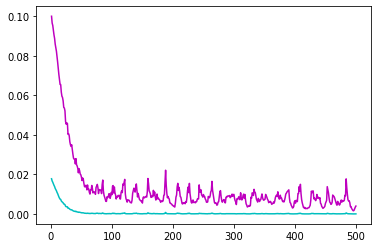

In [39]:
mse_history = history.history['loss']
mae_history = history.history['mae']

epochs = range(1,len(mse_history) +1)
plt.plot(epochs, mse_history, 'c', label='mse')
plt.plot(epochs, mae_history, 'm', label='mae')

# plt.savefig('/content/drive/My Drive/original4800_50epo_mse_mae1.png' ,dpi=1200)

array([-0.83734298, -0.84876688])

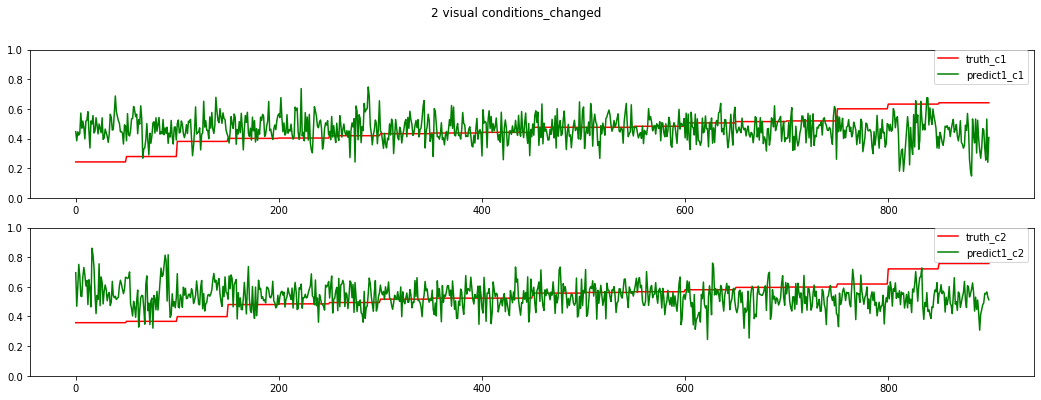

In [31]:
# 这部分是测试集数据部分可视化结果，说明对于测试集模型学的很差

# comparision1 = (model.predict(test_data))*100
# Test_label = test_label*100
tmp = [test_data[:,0],test_data[:,1],test_data[:,2],test_data[:,3],test_data[:,4],
                     test_data[:,5],test_data[:,6],test_data[:,7],test_data[:,8],test_data[:,9],
                     test_data[:,10],test_data[:,11],test_data[:,12],test_data[:,13],test_data[:,14],
                     test_data[:,15],test_data[:,16],test_data[:,17],test_data[:,18],test_data[:,19],
                     test_data[:,20],test_data[:,21],test_data[:,22],test_data[:,23],test_data[:,24],
                     test_data[:,25],test_data[:,26],test_data[:,27],test_data[:,28],test_data[:,29]]
                     
comparision1 = (model.predict(tmp))
Test_label = test_label



# comparision1 , Test_label = shuffle(comparision1, Test_label)
x_data = range(900)
y_data_c1 = Test_label[:,0]
y_data_c2 = Test_label[:,1]

y_predict1_c1 = comparision1[:,0]
y_predict1_c2 = comparision1[:,1]


fig, (predict_c1, predict_c2) = plt.subplots(2,figsize=(18,6))
fig.suptitle('2 visual conditions_changed') 

predict_c1.plot(x_data, y_data_c1[np.argsort(y_data_c1)] , 'r', label='truth_c1')
predict_c2.plot(x_data, y_data_c2[np.argsort(y_data_c2)] , 'r', label='truth_c2')

predict_c1.set_ylim([0,1])
predict_c2.set_ylim([0,1])

predict_c1.plot(x_data, y_predict1_c1[np.argsort(y_data_c1)] , 'g', label='predict1_c1')
predict_c2.plot(x_data, y_predict1_c2[np.argsort(y_data_c2)] , 'g', label='predict1_c2')

predict_c1.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)
predict_c2.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)


# plt.savefig('/content/drive/My Drive/original4800_50epo_comparison1.png' ,dpi=1200)

r2_score(Test_label, comparision1, multioutput='raw_values')

array([0.88515941, 0.87761941])

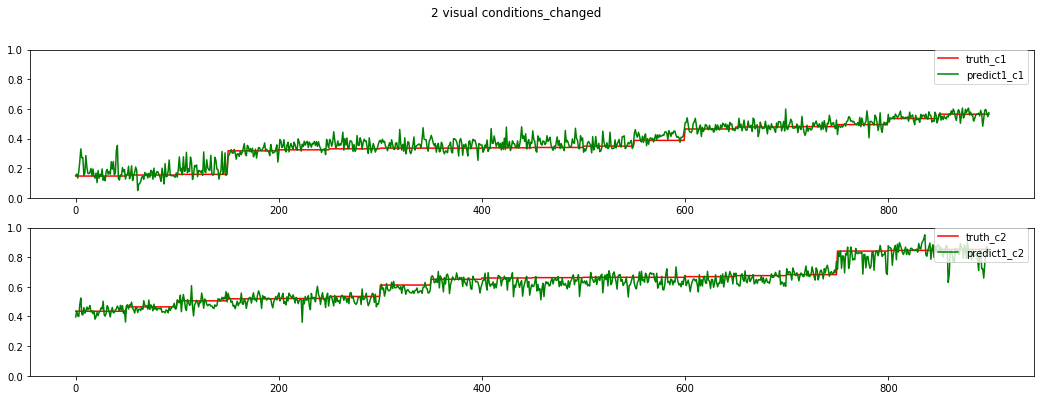

In [0]:
# 这部分是训练集数据部分可视化结果，说明对于训练集模型已经学的很好了
tmp = train_data[:900]
Tmp = train_label[:900]
# comparision1 = (model.predict(test_data))*100
# Test_label = test_label*100
# comparision1 = (model.predict(test_data))
# Test_label = test_label

comparision1 = (model.predict(tmp))
Test_label = Tmp

# comparision1 , Test_label = shuffle(comparision1, Test_label)
x_data = range(900)
y_data_c1 = Test_label[:,0]
y_data_c2 = Test_label[:,1]

y_predict1_c1 = comparision1[:,0]
y_predict1_c2 = comparision1[:,1]


fig, (predict_c1, predict_c2) = plt.subplots(2,figsize=(18,6))
fig.suptitle('2 visual conditions_changed') 

predict_c1.plot(x_data, y_data_c1[np.argsort(y_data_c1)] , 'r', label='truth_c1')
predict_c2.plot(x_data, y_data_c2[np.argsort(y_data_c2)] , 'r', label='truth_c2')

predict_c1.set_ylim([0,1])
predict_c2.set_ylim([0,1])

predict_c1.plot(x_data, y_predict1_c1[np.argsort(y_data_c1)] , 'g', label='predict1_c1')
predict_c2.plot(x_data, y_predict1_c2[np.argsort(y_data_c2)] , 'g', label='predict1_c2')

predict_c1.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)
predict_c2.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)


# plt.savefig('/content/drive/My Drive/original4800_50epo_comparison1.png' ,dpi=1200)

r2_score(Test_label, comparision1, multioutput='raw_values')

# flipped全保留数据 带上control

In [0]:
patient_order = range(1,25)
order = shuffle(patient_order, random_state = 10)
print(patient_order)
print(order)  
# [14, 18, 20, 5, 2, 22, 19, 15, 23, 17, 24, 13, 11, 6, 9, 7, 1, 3, 8, 12, 21, 10, 16, 4]    random_state =20 
# [6, 2, 8, 3, 12, 13, 22, 14, 15, 4, 23, 7, 19, 11, 21, 24, 9, 20, 17, 18, 1, 16, 5, 10]    random_state =10

tmp = order[0]
A = np.load('/content/drive/My Drive/strength/flipped/all/four/' + str(tmp)+ '.npy')
A = np.reshape(A,(200,30,116))
for i in order[1:18]: 
  a = np.load('/content/drive/My Drive/strength/flipped/all/four/' + str(i)+ '.npy')
  a = np.reshape(a,(200,30,116))
  A = np.concatenate((A,a), axis = 0)
print(A.shape)
# 前十八个 病人数据做训练data(3600, 30, 116)


tmp = order[0]
B = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/two_labels/with_control_' + str(tmp)+ '.npy')
for i in order[1:18]: 
  b = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/two_labels/with_control_' + str(i)+ '.npy')
  B = np.concatenate((B,b), axis = 0)
print(B.shape)
# 前十八个 病人数据做训练label(3600, 2)

tmp = order[18]
C = np.load('/content/drive/My Drive/strength/flipped/all/four/' + str(tmp)+ '.npy')
C = np.reshape(C,(200,30,116))
for i in order[19:]: 
  c = np.load('/content/drive/My Drive/strength/flipped/all/four/' + str(i)+ '.npy')
  c = np.reshape(c,(200,30,116))
  C = np.concatenate((C,c), axis = 0)
print(C.shape)
# 后六个人 病人数据做测试data(1200, 30, 116)

tmp = order[18]
D = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/two_labels/with_control_' + str(tmp)+ '.npy')
for i in order[19:]: 
  d = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/two_labels/with_control_' + str(i)+ '.npy')
  D = np.concatenate((D,d), axis = 0)
print(D.shape)
# 后六个人 病人数据做测试label(1200, 2)

# np.save('/content/drive/My Drive/Newdata/ordered_by_patient/train_data_2700_6_116_116_original', A)
# np.save('/content/drive/My Drive/Newdata/ordered_by_patient/train_label_2700_25_3', B)
# np.save('/content/drive/My Drive/Newdata/ordered_by_patient/test_data_900_6_116_116_original', C)
# np.save('/content/drive/My Drive/Newdata/ordered_by_patient/test_label_900_25_3', D)

range(1, 25)
[6, 2, 8, 3, 12, 13, 22, 14, 15, 4, 23, 7, 19, 11, 21, 24, 9, 20, 17, 18, 1, 16, 5, 10]
(3600, 30, 116)
(3600, 2)
(1200, 30, 116)
(1200, 2)


In [0]:
train_data = A
train_label = B
test_data = C
test_label = D

# train_data = np.reshape(train_data,(2700,30,116,1))
# test_data = np.reshape(test_data,(900,30,116,1)) 

train_data = np.reshape(train_data,(3600,30,116,1))
test_data = np.reshape(test_data,(1200,30,116,1)) 

train_data,train_label = shuffle((train_data,train_label), random_state= 10)

print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

(3600, 30, 116, 1)
(3600, 2)
(1200, 30, 116, 1)
(1200, 2)


In [0]:
def Model():
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform', input_shape=(30, 116, 1), padding = 'same'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  # model.add(Conv2D(64, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling2D(pool_size=(2, 2)))
  # model.add(BatchNormalization())
  # model.add(Dropout(0.5))

  model.add(Flatten())
  # model.add(Dense(3200, activation='relu', kernel_initializer='he_uniform'))
  # model.add(Dense(1024, activation='relu', kernel_initializer='he_uniform'))
  # model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
  # model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  # model.add(Dense(3, activation='softmax'))
  model.add(Dense(2))
  model.summary()
  from keras.optimizers import RMSprop,Adam
  model.compile(optimizer = Adam(lr=0.0005),
                loss = 'mean_squared_error',
                metrics = ['mae'])
  return model



In [0]:
num_epochs = 200
batchsize = 50
model = Model()
history = model.fit(train_data, train_label, epochs=num_epochs, batch_size=batchsize, verbose=1)


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 30, 116, 32)       288       
_________________________________________________________________
batch_normalization_7 (Batch (None, 30, 116, 32)       128       
_________________________________________________________________
dropout_7 (Dropout)          (None, 30, 116, 32)       0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 111360)            0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               14254208  
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 258       
Total params: 14,254,882
Trainable params: 14,254,818
Non-trainable params: 64
_________________________________________

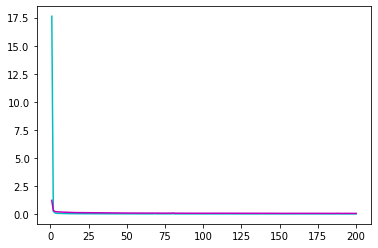

In [0]:
mse_history = history.history['loss']
mae_history = history.history['mae']

epochs = range(1,len(mse_history) +1)
plt.plot(epochs, mse_history, 'c', label='mse')
plt.plot(epochs, mae_history, 'm', label='mae')

# plt.savefig('/content/drive/My Drive/original4800_50epo_mse_mae1.png' ,dpi=1200)

array([-0.865082 , -0.2867081])

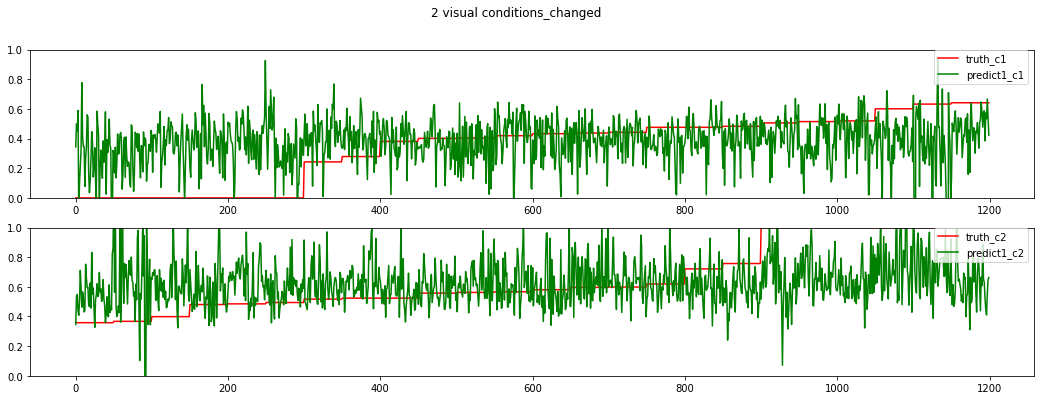

In [0]:
# 这部分是测试集数据部分可视化结果，说明对于测试集模型学的很差

# comparision1 = (model.predict(test_data))*100
# Test_label = test_label*100

comparision1 = (model.predict(test_data))
Test_label = test_label



# comparision1 , Test_label = shuffle(comparision1, Test_label)
x_data = range(1200)
y_data_c1 = Test_label[:,0]
y_data_c2 = Test_label[:,1]

y_predict1_c1 = comparision1[:,0]
y_predict1_c2 = comparision1[:,1]


fig, (predict_c1, predict_c2) = plt.subplots(2,figsize=(18,6))
fig.suptitle('2 visual conditions_changed') 

predict_c1.plot(x_data, y_data_c1[np.argsort(y_data_c1)] , 'r', label='truth_c1')
predict_c2.plot(x_data, y_data_c2[np.argsort(y_data_c2)] , 'r', label='truth_c2')

predict_c1.set_ylim([0,1])
predict_c2.set_ylim([0,1])

predict_c1.plot(x_data, y_predict1_c1[np.argsort(y_data_c1)] , 'g', label='predict1_c1')
predict_c2.plot(x_data, y_predict1_c2[np.argsort(y_data_c2)] , 'g', label='predict1_c2')

predict_c1.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)
predict_c2.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)


# plt.savefig('/content/drive/My Drive/original4800_50epo_comparison1.png' ,dpi=1200)

r2_score(Test_label, comparision1, multioutput='raw_values')

array([0.95386098, 0.96366263])

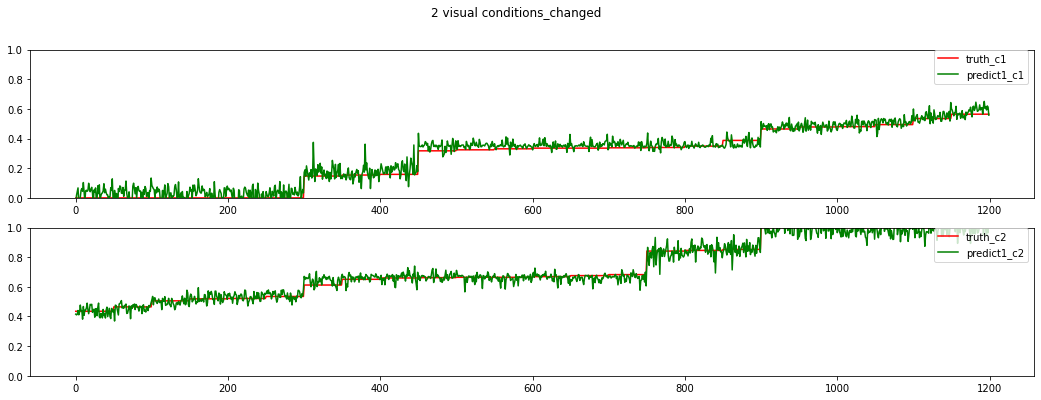

In [0]:
# 这部分是训练集数据部分可视化结果，说明对于训练集模型已经学的很好了
tmp = train_data[:1200]
Tmp = train_label[:1200]
# comparision1 = (model.predict(test_data))*100
# Test_label = test_label*100
# comparision1 = (model.predict(test_data))
# Test_label = test_label

comparision1 = (model.predict(tmp))
Test_label = Tmp

# comparision1 , Test_label = shuffle(comparision1, Test_label)
x_data = range(1200)
y_data_c1 = Test_label[:,0]
y_data_c2 = Test_label[:,1]

y_predict1_c1 = comparision1[:,0]
y_predict1_c2 = comparision1[:,1]


fig, (predict_c1, predict_c2) = plt.subplots(2,figsize=(18,6))
fig.suptitle('2 visual conditions_changed') 

predict_c1.plot(x_data, y_data_c1[np.argsort(y_data_c1)] , 'r', label='truth_c1')
predict_c2.plot(x_data, y_data_c2[np.argsort(y_data_c2)] , 'r', label='truth_c2')

predict_c1.set_ylim([0,1])
predict_c2.set_ylim([0,1])

predict_c1.plot(x_data, y_predict1_c1[np.argsort(y_data_c1)] , 'g', label='predict1_c1')
predict_c2.plot(x_data, y_predict1_c2[np.argsort(y_data_c2)] , 'g', label='predict1_c2')

predict_c1.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)
predict_c2.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)


# plt.savefig('/content/drive/My Drive/original4800_50epo_comparison1.png' ,dpi=1200)

r2_score(Test_label, comparision1, multioutput='raw_values')

# nonflipped保留全部数据strength 并且打平30*116

In [0]:
patient_order = range(1,25)
order = shuffle(patient_order, random_state = 10)
print(patient_order)
print(order)  
# [14, 18, 20, 5, 2, 22, 19, 15, 23, 17, 24, 13, 11, 6, 9, 7, 1, 3, 8, 12, 21, 10, 16, 4]    random_state =20 
# [6, 2, 8, 3, 12, 13, 22, 14, 15, 4, 23, 7, 19, 11, 21, 24, 9, 20, 17, 18, 1, 16, 5, 10]    random_state =10

tmp = order[0]
A = np.load('/content/drive/My Drive/strength/nonflipped/all/three/' + str(tmp)+ '.npy')
A = np.reshape(A,(150,30,116))
for i in order[1:18]: 
  a = np.load('/content/drive/My Drive/strength/nonflipped/all/three/' + str(i)+ '.npy')
  a = np.reshape(a,(150,30,116))
  A = np.concatenate((A,a), axis = 0)
print(A.shape)
# 前十八个 病人数据做训练data(2700, 30, 116)


# tmp = order[0]
# B = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/percent_output_' + str(tmp)+ '.npy')
# for i in order[1:18]: 
#   b = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/percent_output_' + str(i)+ '.npy')
#   B = np.concatenate((B,b), axis = 0)
# print(B.shape)
# # 前十八个 病人数据做训练label(2700, 3)

tmp = order[0]
B = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/4/output_' + str(tmp)+ '.npy')
for i in order[1:18]: 
  b = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/4/output_' + str(i)+ '.npy')
  B = np.concatenate((B,b), axis = 0)
print(B.shape)
# 前十八个 病人数据做训练label(2700, 3)

tmp = order[18]
C = np.load('/content/drive/My Drive/strength/nonflipped/all/three/' + str(tmp)+ '.npy')
C = np.reshape(C,(150,30,116))
for i in order[19:]: 
  c = np.load('/content/drive/My Drive/strength/nonflipped/all/three/' + str(i)+ '.npy')
  c = np.reshape(c,(150,30,116))
  C = np.concatenate((C,c), axis = 0)
print(C.shape)
# 后六个人 病人数据做测试data(900, 30, 116)

# tmp = order[18]
# D = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/percent_output_' + str(tmp)+ '.npy')
# for i in order[19:]: 
#   d = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/percent_output_' + str(i)+ '.npy')
#   D = np.concatenate((D,d), axis = 0)
# print(D.shape)
# # 后六个人 病人数据做测试label(900, 3)

tmp = order[18]
D = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/4/output_' + str(tmp)+ '.npy')
for i in order[19:]: 
  d = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/4/output_' + str(i)+ '.npy')
  D = np.concatenate((D,d), axis = 0)
print(D.shape)
# 后六个人 病人数据做测试label(900, 3)

# np.save('/content/drive/My Drive/Newdata/ordered_by_patient/train_data_2700_6_116_116_original', A)
# np.save('/content/drive/My Drive/Newdata/ordered_by_patient/train_label_2700_25_3', B)
# np.save('/content/drive/My Drive/Newdata/ordered_by_patient/test_data_900_6_116_116_original', C)
# np.save('/content/drive/My Drive/Newdata/ordered_by_patient/test_label_900_25_3', D)

range(1, 25)
[6, 2, 8, 3, 12, 13, 22, 14, 15, 4, 23, 7, 19, 11, 21, 24, 9, 20, 17, 18, 1, 16, 5, 10]
(2700, 30, 116)
(2700, 4, 3)
(900, 30, 116)
(900, 4, 3)


In [0]:
train_data = A
train_label = B
test_data = C
test_label = D

# train_data = np.reshape(train_data,(2700,30,116,1))
# test_data = np.reshape(test_data,(900,30,116,1)) 

train_data = np.reshape(train_data,(2700,3480))
test_data = np.reshape(test_data,(900,3480)) 

print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

(2700, 3480)
(2700, 4, 3)
(900, 3480)
(900, 4, 3)


In [0]:
#He正态分布初始化方法，参数由0均值，标准差为sqrt(2 / fan_in) 的正态分布产生，其中fan_in权重张量的扇入
def Functional_model():  
   # This returns a tensor# a layer instance is callable on a tensor, and returns a tensor
  x_input = Input(shape=(3480,))
  x = layers.Dense(1024, activation='relu', kernel_initializer='lecun_uniform')(x_input) 
  x = layers.Dense(512, activation='relu', kernel_initializer='lecun_uniform')(x)
  x = layers.Dense(256, activation='relu', kernel_initializer='lecun_uniform')(x)
  x = layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform')(x)
  # x = layers.Dense(32, activation='relu', kernel_initializer='lecun_uniform')(x)
  # x = layers.Dense(16, activation='relu', kernel_initializer='lecun_uniform')(x) 
  # x = layers.Dense(8, activation='relu', kernel_initializer='lecun_uniform')(x) 
  
  y1 = layers.Dense(3,activation='sigmoid', name = 'y1')(x)
  y2 = layers.Dense(3,activation='sigmoid', name = 'y2')(x)
  y3 = layers.Dense(3,activation='sigmoid', name = 'y3')(x)
  y4 = layers.Dense(3,activation='sigmoid', name = 'y4')(x)
  

  # This creates a model that includes
  model = Model(inputs=x_input, outputs=[y1,y2,y3,y4
                                        #  ,y5,y6,y7,y8,y9,y10,y11,y12,y13,y14,y15,y16
                                        #  ,y17,y18,y19,y20,y21,y22,y23,y24,y25
                                         ])
  model.summary() 
  model.compile(optimizer = Adam(lr=0.0003),
                loss=['categorical_crossentropy','categorical_crossentropy','categorical_crossentropy','categorical_crossentropy'
                # ,'categorical_crossentropy','categorical_crossentropy','categorical_crossentropy','categorical_crossentropy',
                # 'categorical_crossentropy','categorical_crossentropy','categorical_crossentropy','categorical_crossentropy',
                # 'categorical_crossentropy','categorical_crossentropy','categorical_crossentropy','categorical_crossentropy'
                # ,'categorical_crossentropy','categorical_crossentropy','categorical_crossentropy','categorical_crossentropy',
                # 'categorical_crossentropy','categorical_crossentropy','categorical_crossentropy','categorical_crossentropy',
                # 'categorical_crossentropy'
                ],
                metrics=['accuracy'])
  return model 

In [0]:
# def Model():
#   # input_shape=(116,30)
#   model = Sequential()
  

#   # model.add(Flatten())
#   # model.add(Dense(3200, activation='relu', kernel_initializer='he_uniform'))
#   model.add(Dense(1024, activation='relu', kernel_initializer='he_uniform',input_shape=(3480,)))
#   model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
#   model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
#   model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
#   # model.add(Dense(3, activation='softmax'))
#   model.add(Dense(3,activation='sigmoid')
#   model.summary()
#   from keras.optimizers import RMSprop,Adam
#   model.compile(optimizer = Adam(lr=0.0003),
#                 loss = 'mean_squared_error',
#                 metrics = ['mae'])
#   return model



In [0]:
# num_epochs = 500
# batchsize = 50
# model = Model()
# history = model.fit(train_data, train_label, epochs=num_epochs, batch_size=batchsize, verbose=1)


In [0]:
num_epochs = 500
batchsize = 50
model = Functional_model()
history = model.fit(train_data, [train_label[:,0],train_label[:,1],
                                 train_label[:,2],train_label[:,3]], epochs=num_epochs, batch_size=batchsize, verbose=1)


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 3480)         0                                            
__________________________________________________________________________________________________
dense_54 (Dense)                (None, 1024)         3564544     input_4[0][0]                    
__________________________________________________________________________________________________
dense_55 (Dense)                (None, 512)          524800      dense_54[0][0]                   
__________________________________________________________________________________________________
dense_56 (Dense)                (None, 256)          131328      dense_55[0][0]                   
____________________________________________________________________________________________

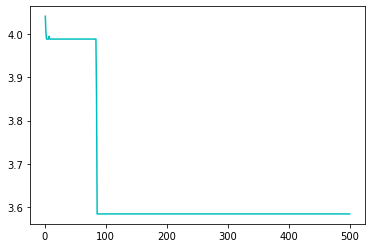

In [0]:
mse_history = history.history['loss']
# mae_history = history.history['y3_accuracy']

epochs = range(1,len(mse_history) +1)
plt.plot(epochs, mse_history, 'c', label='mse')
# plt.plot(epochs, mae_history, 'm', label='mae')

# plt.savefig('/content/drive/My Drive/original4800_50epo_mse_mae1.png' ,dpi=1200)

In [0]:
test = model.evaluate(test_data, [test_label[:,0],test_label[:,1],test_label[:,2],test_label[:,3]
                                  # ,test_label[:,4] ,test_label[:,5],test_label[:,6],test_label[:,7],
                                #  test_label[:,8],test_label[:,9],test_label[:,10],test_label[:,11],test_label[:,12],test_label[:,13],test_label[:,14],test_label[:,15]
                                #   ,test_label[:,16],test_label[:,17],test_label[:,18],test_label[:,19],test_label[:,20],test_label[:,21],test_label[:,22],test_label[:,23],
                                #  test_label[:,24]
                                  ], verbose=0)
# print(test)
average = 5
mean = np.mean(test[average:])
print(len(test[average:]))

print(mean)

4
0.3750000037252903


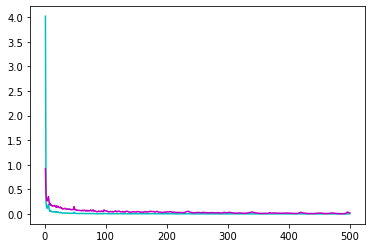

In [0]:
mse_history = history.history['loss']
mae_history = history.history['mae']

epochs = range(1,len(mse_history) +1)
plt.plot(epochs, mse_history, 'c', label='mse')
plt.plot(epochs, mae_history, 'm', label='mae')

# plt.savefig('/content/drive/My Drive/original4800_50epo_mse_mae1.png' ,dpi=1200)

In [0]:
tmp = train_data[:1000]
Tmp = train_label[:1000]

array([-0.47498986, -0.8550067 , -0.94826156])

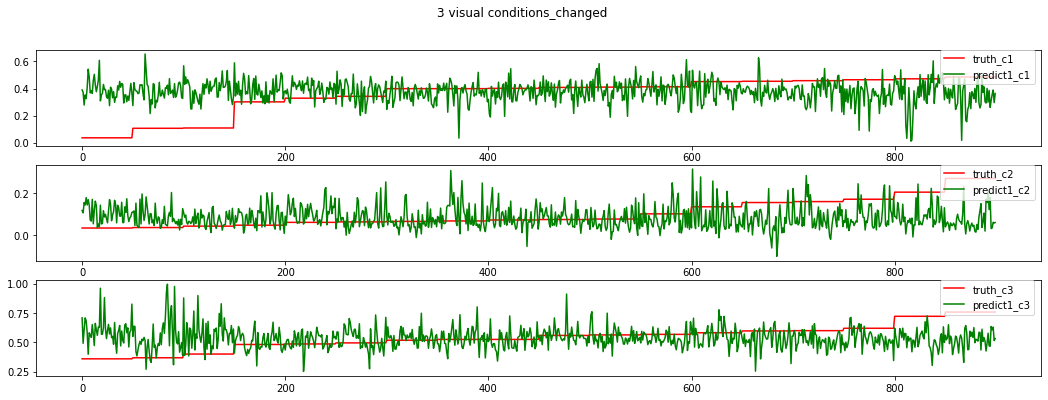

In [0]:

# comparision1 = (model.predict(test_data))*100
# Test_label = test_label*100

comparision1 = (model.predict(test_data))
Test_label = test_label

# comparision1 = (model.predict(tmp))
# Test_label = Tmp

# comparision1 , Test_label = shuffle(comparision1, Test_label)
x_data = range(900)
y_data_c1 = Test_label[:,0]
y_data_c2 = Test_label[:,1]
y_data_c3 = Test_label[:,2]
y_predict1_c1 = comparision1[:,0]
y_predict1_c2 = comparision1[:,1]
y_predict1_c3 = comparision1[:,2]

fig, (predict_c1, predict_c2, predict_c3) = plt.subplots(3,figsize=(18,6))
fig.suptitle('3 visual conditions_changed') 

predict_c1.plot(x_data, y_data_c1[np.argsort(y_data_c1)] , 'r', label='truth_c1')
predict_c2.plot(x_data, y_data_c2[np.argsort(y_data_c2)] , 'r', label='truth_c2')
predict_c3.plot(x_data, y_data_c3[np.argsort(y_data_c3)] , 'r', label='truth_c3')
predict_c1.plot(x_data, y_predict1_c1[np.argsort(y_data_c1)] , 'g', label='predict1_c1')
predict_c2.plot(x_data, y_predict1_c2[np.argsort(y_data_c2)] , 'g', label='predict1_c2')
predict_c3.plot(x_data, y_predict1_c3[np.argsort(y_data_c3)] , 'g', label='predict1_c3')
predict_c1.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)
predict_c2.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)
predict_c3.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)

# plt.savefig('/content/drive/My Drive/original4800_50epo_comparison1.png' ,dpi=1200)

r2_score(Test_label, comparision1, multioutput='raw_values')

# Nonflipped 4种全部

In [0]:
patient_order = range(1,25)
order = shuffle(patient_order, random_state = 10)
print(patient_order)
print(order)  
# [14, 18, 20, 5, 2, 22, 19, 15, 23, 17, 24, 13, 11, 6, 9, 7, 1, 3, 8, 12, 21, 10, 16, 4]    random_state =20 
# [6, 2, 8, 3, 12, 13, 22, 14, 15, 4, 23, 7, 19, 11, 21, 24, 9, 20, 17, 18, 1, 16, 5, 10]    random_state =10

tmp = order[0]
A = np.load('/content/drive/My Drive/strength/nonflipped/all/four/' + str(tmp)+ '.npy')
A = np.reshape(A,(200,30,116))
for i in order[1:18]: 
  a = np.load('/content/drive/My Drive/strength/nonflipped/all/four/' + str(i)+ '.npy')
  a = np.reshape(a,(200,30,116))
  A = np.concatenate((A,a), axis = 0)
print(A.shape)
# 前十八个 病人数据做训练data(3600, 30, 116)


tmp = order[0]
B = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/percent_output_with_control_' + str(tmp)+ '.npy')
for i in order[1:18]: 
  b = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/percent_output_with_control_' + str(i)+ '.npy')
  B = np.concatenate((B,b), axis = 0)
print(B.shape)
# 前十八个 病人数据做训练label(3600, 3)

tmp = order[18]
C = np.load('/content/drive/My Drive/strength/nonflipped/all/four/' + str(tmp)+ '.npy')
C = np.reshape(C,(200,30,116))
for i in order[19:]: 
  c = np.load('/content/drive/My Drive/strength/nonflipped/all/four/' + str(i)+ '.npy')
  c = np.reshape(c,(200,30,116))
  C = np.concatenate((C,c), axis = 0)
print(C.shape)
# 后六个人 病人数据做测试data(1200, 30, 116)

tmp = order[18]
D = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/percent_output_with_control_' + str(tmp)+ '.npy')
for i in order[19:]: 
  d = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/percent_output_with_control_' + str(i)+ '.npy')
  D = np.concatenate((D,d), axis = 0)
print(D.shape)
# 后六个人 病人数据做测试label(1200, 3)

# np.save('/content/drive/My Drive/Newdata/ordered_by_patient/train_data_2700_6_116_116_original', A)
# np.save('/content/drive/My Drive/Newdata/ordered_by_patient/train_label_2700_25_3', B)
# np.save('/content/drive/My Drive/Newdata/ordered_by_patient/test_data_900_6_116_116_original', C)
# np.save('/content/drive/My Drive/Newdata/ordered_by_patient/test_label_900_25_3', D)

range(1, 25)
[6, 2, 8, 3, 12, 13, 22, 14, 15, 4, 23, 7, 19, 11, 21, 24, 9, 20, 17, 18, 1, 16, 5, 10]
(3600, 30, 116)
(3600, 3)
(1200, 30, 116)
(1200, 3)


In [0]:
train_data = A
train_label = B
test_data = C
test_label = D

train_data = np.reshape(train_data,(3600,30,116,1))
test_data = np.reshape(test_data,(1200,30,116,1)) 

train_data,train_label = shuffle((train_data,train_label), random_state= 10)

print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

(3600, 30, 116, 1)
(3600, 3)
(1200, 30, 116, 1)
(1200, 3)


In [0]:
def Model():
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform', input_shape=(30, 116, 1)))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(64, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(128, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  # model.add(Conv2D(256, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling2D(pool_size=(2, 2)))
  # model.add(BatchNormalization())
  # model.add(Dropout(0.5))
  model.add(Conv2D(128, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(64, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(32, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  # model.add(Conv2D(32, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling2D(pool_size=(2, 2)))
  # model.add(BatchNormalization())
  # model.add(Dropout(0.5))
  # model.add(Conv2D(32, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling2D(pool_size=(2, 2)))
  # model.add(BatchNormalization())
  # model.add(Dropout(0.5))
  # model.add(Conv2D(32, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling2D(pool_size=(2, 2)))
  # model.add(BatchNormalization())
  # model.add(Dropout(0.5))
  # model.add(Conv2D(32, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling2D(pool_size=(2, 2)))
  # model.add(BatchNormalization())
  # model.add(Dropout(0.5))

  model.add(Flatten())
  # model.add(Dense(3200, activation='relu', kernel_initializer='he_uniform'))
  # model.add(Dense(1024, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  # model.add(Dense(3, activation='softmax'))
  model.add(Dense(3))
  model.summary()
  from keras.optimizers import RMSprop,Adam
  model.compile(optimizer = Adam(lr=0.0001),
                loss = 'mean_squared_error',
                metrics = ['mae'])
  return model



In [0]:
num_epochs = 50
batchsize = 12
model = Model()
history = model.fit(train_data, train_label, epochs=num_epochs, batch_size=batchsize, verbose=1)


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_63 (Conv2D)           (None, 29, 113, 32)       288       
_________________________________________________________________
batch_normalization_63 (Batc (None, 29, 113, 32)       128       
_________________________________________________________________
dropout_63 (Dropout)         (None, 29, 113, 32)       0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 28, 110, 64)       16448     
_________________________________________________________________
batch_normalization_64 (Batc (None, 28, 110, 64)       256       
_________________________________________________________________
dropout_64 (Dropout)         (None, 28, 110, 64)       0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 27, 107, 128)     

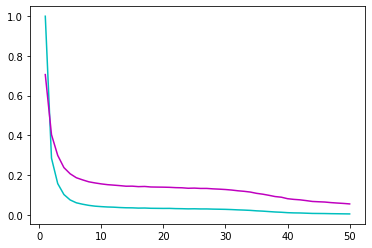

In [0]:
mse_history = history.history['loss']
mae_history = history.history['mae']

epochs = range(1,len(mse_history) +1)
plt.plot(epochs, mse_history, 'c', label='mse')
plt.plot(epochs, mae_history, 'm', label='mae')

# plt.savefig('/content/drive/My Drive/original4800_50epo_mse_mae1.png' ,dpi=1200)

array([-0.63693396, -0.93233456, -0.64925142])

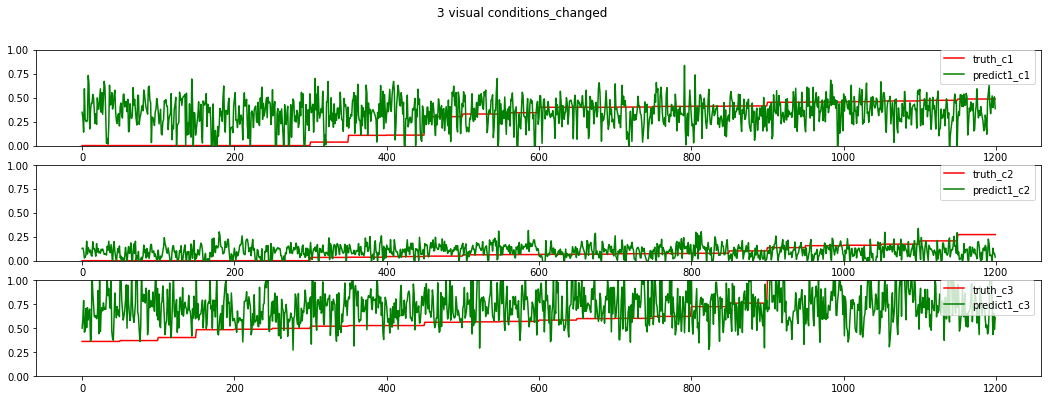

In [0]:

# comparision1 = (model.predict(test_data))*100
# Test_label = test_label*100
comparision1 = (model.predict(test_data))
Test_label = test_label
# comparision1 , Test_label = shuffle(comparision1, Test_label)
x_data = range(1200)
y_data_c1 = Test_label[:,0]
y_data_c2 = Test_label[:,1]
y_data_c3 = Test_label[:,2]
predict_c1.set_ylim([0,1])
predict_c2.set_ylim([0,1])
predict_c3.set_ylim([0,1])
y_predict1_c1 = comparision1[:,0]
y_predict1_c2 = comparision1[:,1]
y_predict1_c3 = comparision1[:,2]

fig, (predict_c1, predict_c2, predict_c3) = plt.subplots(3,figsize=(18,6))
fig.suptitle('3 visual conditions_changed') 

predict_c1.plot(x_data, y_data_c1[np.argsort(y_data_c1)] , 'r', label='truth_c1')
predict_c2.plot(x_data, y_data_c2[np.argsort(y_data_c2)] , 'r', label='truth_c2')
predict_c3.plot(x_data, y_data_c3[np.argsort(y_data_c3)] , 'r', label='truth_c3')
predict_c1.set_ylim([0,1])
predict_c2.set_ylim([0,1])
predict_c3.set_ylim([0,1])
predict_c1.plot(x_data, y_predict1_c1[np.argsort(y_data_c1)] , 'g', label='predict1_c1')
predict_c2.plot(x_data, y_predict1_c2[np.argsort(y_data_c2)] , 'g', label='predict1_c2')
predict_c3.plot(x_data, y_predict1_c3[np.argsort(y_data_c3)] , 'g', label='predict1_c3')
predict_c1.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)
predict_c2.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)
predict_c3.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)

# plt.savefig('/content/drive/My Drive/original4800_50epo_comparison1.png' ,dpi=1200)

r2_score(Test_label, comparision1, multioutput='raw_values')

# flipped 4种0.3

In [0]:
patient_order = range(1,25)
order = shuffle(patient_order, random_state = 10)
print(patient_order)
print(order)  
# [14, 18, 20, 5, 2, 22, 19, 15, 23, 17, 24, 13, 11, 6, 9, 7, 1, 3, 8, 12, 21, 10, 16, 4]    random_state =20 
# [6, 2, 8, 3, 12, 13, 22, 14, 15, 4, 23, 7, 19, 11, 21, 24, 9, 20, 17, 18, 1, 16, 5, 10]    random_state =10

tmp = order[0]
A = np.load('/content/drive/My Drive/strength/flipped/keep_30/four' + str(tmp)+ '.npy')
A = np.reshape(A,(200,30,116))
for i in order[1:18]: 
  a = np.load('/content/drive/My Drive/strength/flipped/keep_30/four' + str(i)+ '.npy')
  a = np.reshape(a,(200,30,116))
  A = np.concatenate((A,a), axis = 0)
print(A.shape)
# 前十八个 病人数据做训练data(3600, 30, 116)


tmp = order[0]
B = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/percent_output_with_control_' + str(tmp)+ '.npy')
for i in order[1:18]: 
  b = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/percent_output_with_control_' + str(i)+ '.npy')
  B = np.concatenate((B,b), axis = 0)
print(B.shape)
# 前十八个 病人数据做训练label(3600, 3)

tmp = order[18]
C = np.load('/content/drive/My Drive/strength/flipped/keep_30/four' + str(tmp)+ '.npy')
C = np.reshape(C,(200,30,116))
for i in order[19:]: 
  c = np.load('/content/drive/My Drive/strength/flipped/keep_30/four' + str(i)+ '.npy')
  c = np.reshape(c,(200,30,116))
  C = np.concatenate((C,c), axis = 0)
print(C.shape)
# 后六个人 病人数据做测试data(1200, 30, 116)

tmp = order[18]
D = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/percent_output_with_control_' + str(tmp)+ '.npy')
for i in order[19:]: 
  d = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/percent_output_with_control_' + str(i)+ '.npy')
  D = np.concatenate((D,d), axis = 0)
print(D.shape)
# 后六个人 病人数据做测试label(1200, 3)

# np.save('/content/drive/My Drive/Newdata/ordered_by_patient/train_data_2700_6_116_116_original', A)
# np.save('/content/drive/My Drive/Newdata/ordered_by_patient/train_label_2700_25_3', B)
# np.save('/content/drive/My Drive/Newdata/ordered_by_patient/test_data_900_6_116_116_original', C)
# np.save('/content/drive/My Drive/Newdata/ordered_by_patient/test_label_900_25_3', D)

In [0]:
train_data = A
train_label = B
test_data = C
test_label = D

train_data = np.reshape(train_data,(3600,30,116,1))
test_data = np.reshape(test_data,(1200,30,116,1)) 

train_data,train_label = shuffle((train_data,train_label), random_state= 10)

print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

In [0]:
def Model():
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform', input_shape=(30, 116, 1)))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(64, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(128, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(256, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(128, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(64, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(32, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(32, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(32, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(32, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(32, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Flatten())
  # model.add(Dense(3200, activation='relu', kernel_initializer='he_uniform'))
  # model.add(Dense(1024, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  # model.add(Dense(3, activation='softmax'))
  model.add(Dense(3))
  model.summary()
  from keras.optimizers import RMSprop,Adam
  model.compile(optimizer = Adam(lr=0.0001),
                loss = 'mean_squared_error',
                metrics = ['mae'])
  return model



In [0]:
num_epochs = 50
batchsize = 12
model = Model()
history = model.fit(train_data, train_label, epochs=num_epochs, batch_size=batchsize, verbose=1)


In [0]:
mse_history = history.history['loss']
mae_history = history.history['mae']

epochs = range(1,len(mse_history) +1)
plt.plot(epochs, mse_history, 'c', label='mse')
plt.plot(epochs, mae_history, 'm', label='mae')

# plt.savefig('/content/drive/My Drive/original4800_50epo_mse_mae1.png' ,dpi=1200)

In [0]:

# comparision1 = (model.predict(test_data))*100
# Test_label = test_label*100
comparision1 = (model.predict(test_data))
Test_label = test_label
# comparision1 , Test_label = shuffle(comparision1, Test_label)
x_data = range(1200)
y_data_c1 = Test_label[:,0]
y_data_c2 = Test_label[:,1]
y_data_c3 = Test_label[:,2]
y_predict1_c1 = comparision1[:,0]
y_predict1_c2 = comparision1[:,1]
y_predict1_c3 = comparision1[:,2]

fig, (predict_c1, predict_c2, predict_c3) = plt.subplots(3,figsize=(18,6))
fig.suptitle('3 visual conditions_changed') 

predict_c1.plot(x_data, y_data_c1[np.argsort(y_data_c1)] , 'r', label='truth_c1')
predict_c2.plot(x_data, y_data_c2[np.argsort(y_data_c2)] , 'r', label='truth_c2')
predict_c3.plot(x_data, y_data_c3[np.argsort(y_data_c3)] , 'r', label='truth_c3')
predict_c1.plot(x_data, y_predict1_c1[np.argsort(y_data_c1)] , 'g', label='predict1_c1')
predict_c2.plot(x_data, y_predict1_c2[np.argsort(y_data_c2)] , 'g', label='predict1_c2')
predict_c3.plot(x_data, y_predict1_c3[np.argsort(y_data_c3)] , 'g', label='predict1_c3')
predict_c1.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)
predict_c2.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)
predict_c3.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)

# plt.savefig('/content/drive/My Drive/original4800_50epo_comparison1.png' ,dpi=1200)

r2_score(Test_label, comparision1, multioutput='raw_values')

# 把30赫兹频率变成6个 

In [0]:
def from_30_to_6(Num):
  data = Num[:]
  New_6 = []
  for i in range(150):

  # i = 0
    delta = (data[i,0] + data[i,1] + data[i,2])/3 
    delta = np.reshape(delta, (1,116,116))
    theta = (data[i,3] + data[i,4] + data[i,5] + data[i,6])/4 
    theta = np.reshape(theta, (1,116,116))
    alpha_low = (data[i,7] + data[i,8] + data[i,9])/3  
    alpha_low = np.reshape(alpha_low, (1,116,116))
    alpha_high = (data[i,10] + data[i,11] + data[i,12])/3  
    alpha_high = np.reshape(alpha_high, (1,116,116))
    beta_1 = (data[i,13] + data[i,14] + data[i,15] + data[i,16] + data[i,17] + data[i,18] + data[i,19] + data[i,20])/8 
    beta_1 = np.reshape(beta_1, (1,116,116))
    beta_2 = (data[i,21] + data[i,22] + data[i,23] + data[i,24] + data[i,25] + data[i,26] + data[i,27] + data[i,28] + data[i,29])/9 
    beta_2 = np.reshape(beta_2, (1,116,116))
    new_6 = np.concatenate((delta,theta,alpha_low,alpha_high,beta_1,beta_2), axis = 0) 
    New_6.append(new_6)
    new_6 = 0

  New_6  = np.array(New_6)
  return New_6

In [0]:
for i in range(1,25):
  Num = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/115_30_116_116_' + str(i) + '.npy')
  tmp = from_30_to_6(Num)
  np.save('/content/drive/My Drive/Newdata/ordered_by_patient/150_6_116_116_' + str(i)+ '.npy', tmp)
#这里保存的是没有flipped的数据  按24个病人来分的

In [0]:
aaa = np.load('/content/drive/My Drive/Newdata/changed/allpre.npy')
bbb = np.load('/content/drive/My Drive/Newdata/changed/allpost.npy')
ccc = np.load('/content/drive/My Drive/Newdata/changed/allfu.npy')

In [0]:
for i in range(24):
# i = 1

  Num = np.concatenate((aaa[i*50:(i+1)*50],bbb[i*50:(i+1)*50],ccc[i*50:(i+1)*50]), axis = 0)
  tmp = from_30_to_6(Num)
  np.save('/content/drive/My Drive/Newdata/ordered_by_patient/150_6_116_116_' + str(i+1)+ '_flipped.npy', tmp)
# 这里保存的是 flipped后的数据   按24个病人来分的
  # print(i)

# 载入非flipped数据


In [0]:
train_data = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/train_data_2700_6_116_116_original.npy')
train_label = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/train_label_2700_25_3.npy')
test_data =  np.load('/content/drive/My Drive/Newdata/ordered_by_patient/test_data_900_6_116_116_original.npy')
test_label = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/test_label_900_25_3.npy')

# train_data = A
# train_label = B
# test_data = C
# test_label = D

train_data = np.reshape(train_data,(2700,6,116,116,1))
test_data = np.reshape(test_data,(900,6,116,116,1)) 

print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

(2700, 6, 116, 116, 1)
(2700, 3)
(900, 6, 116, 116, 1)
(900, 3)


# 载入flipped数据

In [0]:
patient_order = range(1,25)
order = shuffle(patient_order, random_state = 10)
print(patient_order)
print(order)  
# [14, 18, 20, 5, 2, 22, 19, 15, 23, 17, 24, 13, 11, 6, 9, 7, 1, 3, 8, 12, 21, 10, 16, 4]    random_state =20 
# [6, 2, 8, 3, 12, 13, 22, 14, 15, 4, 23, 7, 19, 11, 21, 24, 9, 20, 17, 18, 1, 16, 5, 10]    random_state =10

tmp = order[0]
A = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/150_6_116_116_' + str(tmp)+ '_flipped.npy')
for i in order[1:18]: 
  a = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/150_6_116_116_' + str(i)+ '_flipped.npy')
  A = np.concatenate((A,a), axis = 0)
print(A.shape)
# 前十八个 病人数据做训练data(2700, 30, 116, 116)


# tmp = order[0]
# B = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/percent_output_' + str(tmp)+ '.npy')
# for i in order[1:18]: 
#   b = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/percent_output_' + str(i)+ '.npy')
#   B = np.concatenate((B,b), axis = 0)
# print(B.shape)
# # 前十八个 病人数据做训练label(2700, 21, 21)

tmp = order[18]
C = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/150_6_116_116_' + str(tmp)+ '_flipped.npy')
for i in order[19:]: 
  c = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/150_6_116_116_' + str(i)+ '_flipped.npy')
  C = np.concatenate((C,c), axis = 0)
print(C.shape)
# 后六个人 病人数据做测试data(900, 30, 116, 116)

# tmp = order[18]
# D = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/percent_output_' + str(tmp)+ '.npy')
# for i in order[19:]: 
#   d = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/percent_output_' + str(i)+ '.npy')
#   D = np.concatenate((D,d), axis = 0)
# print(D.shape)
# # 后六个人 病人数据做测试label(900, 21, 21)

np.save('/content/drive/My Drive/Newdata/ordered_by_patient/train_data_2700_6_116_116_flipped', A)
# np.save('/content/drive/My Drive/Newdata/ordered_by_patient/train_label_2700_25_3', B)
np.save('/content/drive/My Drive/Newdata/ordered_by_patient/test_data_900_6_116_116_flipped', C)
# np.save('/content/drive/My Drive/Newdata/ordered_by_patient/test_label_900_25_3', D)

range(1, 25)
[6, 2, 8, 3, 12, 13, 22, 14, 15, 4, 23, 7, 19, 11, 21, 24, 9, 20, 17, 18, 1, 16, 5, 10]
(2700, 6, 116, 116)
(900, 6, 116, 116)


In [0]:
# train_data = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/train_data_2700_6_116_116_flipped.npy')
train_label = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/train_label_2700_25_3.npy')
# test_data =  np.load('/content/drive/My Drive/Newdata/ordered_by_patient/test_data_900_6_116_116_flipped.npy')
test_label = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/test_label_900_25_3.npy')

train_data = A
# train_label = B
test_data = C
# test_label = D

train_data = np.reshape(train_data,(2700,6,116,116,1))
test_data = np.reshape(test_data,(900,6,116,116,1)) 

print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

(2700, 6, 116, 116, 1)
(2700, 3)
(900, 6, 116, 116, 1)
(900, 3)


# 模型部分

In [0]:
def Model():
  model = Sequential()
  model.add(Conv3D(128, kernel_size=(1, 6, 6), activation='relu', kernel_initializer='he_uniform', input_shape=(6,116,116, 1)))
  model.add(MaxPooling3D(pool_size=(1, 2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv3D(64, kernel_size=(1, 6, 6), activation='relu', kernel_initializer='he_uniform'))
  model.add(MaxPooling3D(pool_size=(1, 2, 2)))
  model.add(BatchNormalization()) 
  model.add(Dropout(0.5))
  model.add(Conv3D(32, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  model.add(MaxPooling3D(pool_size=(1, 2, 2)))
  model.add(Dropout(0.5))
  model.add(BatchNormalization())
  # model.add(Conv3D(30, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(40, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(50, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(60, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(70, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(80, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(90, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(100, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(90, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(80, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(70, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(60, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(50, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(40, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(30, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(20, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(10, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # model.add(Dropout(0.5))
  model.add(Flatten())
  # model.add(Dense(3200, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(1028, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  # model.add(Dense(3, activation='softmax'))
  model.add(Dense(3))
  model.summary()
  from keras.optimizers import RMSprop,Adam
  model.compile(optimizer = Adam(lr=0.0001),
                loss = 'mean_squared_error',
                metrics = ['mae'])
  return model



In [0]:

# data = np.load('/content/drive/My Drive/Newdata/shuffle_originalin3600.npy')
# label =  np.load('/content/drive/My Drive/Newdata/shuffle_originalout3600.npy')
# k = 5
# num_val_samples = len(data)//k
# # for i in range(k):
# i = 2
# print('processing fold #', i)
# test_data = data[i * num_val_samples: (i + 1) * num_val_samples]
# test_label = label[i * num_val_samples: (i + 1) * num_val_samples]
# train_data = np.concatenate([data[:i * num_val_samples],data[(i + 1) * num_val_samples:]], axis=0)
# train_label = np.concatenate([label[:i * num_val_samples],label[(i + 1) * num_val_samples:]], axis=0)
# np.save('/content/drive/My Drive/Newdata/'+str(i)+'_fold_trainin_original3600', train_data)
# # np.save('/content/drive/My Drive/Newdata/'+str(i)+'_fold_trainout_original3600', train_label)
# # np.save('/content/drive/My Drive/Newdata/'+str(i)+'_fold_testin_original3600', test_data)
# # np.save('/content/drive/My Drive/Newdata/'+str(i)+'_fold_testout_original3600', test_label)



# 跑模型

In [0]:
num_epochs = 50
batchsize = 12
model = Model()
history = model.fit(train_data, train_label, epochs=num_epochs, batch_size=batchsize, verbose=1)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 6, 111, 111, 128)  4736      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 6, 55, 55, 128)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 55, 55, 128)    512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 55, 55, 128)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 6, 50, 50, 64)     294976    
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 6, 25, 25, 64)     0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 6, 25, 25, 64)    

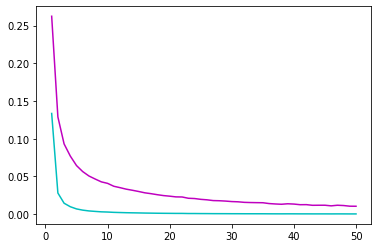

In [0]:
mse_history = history.history['loss']
mae_history = history.history['mae']

epochs = range(1,len(mse_history) +1)
plt.plot(epochs, mse_history, 'c', label='mse')
plt.plot(epochs, mae_history, 'm', label='mae')

# plt.savefig('/content/drive/My Drive/original4800_50epo_mse_mae1.png' ,dpi=1200)

array([-1.63628163, -0.43724307, -1.03029477])

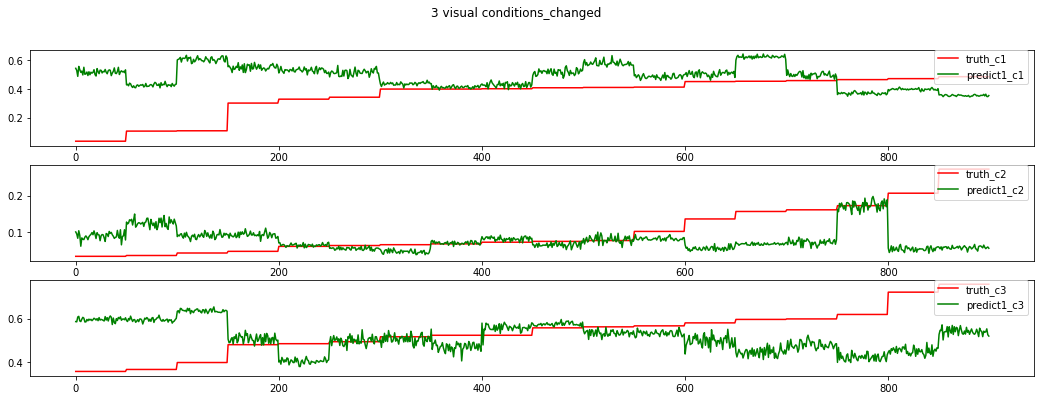

In [0]:

# comparision1 = (model.predict(test_data))*100
# Test_label = test_label*100
comparision1 = (model.predict(test_data))
Test_label = test_label
# comparision1 , Test_label = shuffle(comparision1, Test_label)
x_data = range(900)
y_data_c1 = Test_label[:,0]
y_data_c2 = Test_label[:,1]
y_data_c3 = Test_label[:,2]
y_predict1_c1 = comparision1[:,0]
y_predict1_c2 = comparision1[:,1]
y_predict1_c3 = comparision1[:,2]

fig, (predict_c1, predict_c2, predict_c3) = plt.subplots(3,figsize=(18,6))
fig.suptitle('3 visual conditions_changed') 

predict_c1.plot(x_data, y_data_c1[np.argsort(y_data_c1)] , 'r', label='truth_c1')
predict_c2.plot(x_data, y_data_c2[np.argsort(y_data_c2)] , 'r', label='truth_c2')
predict_c3.plot(x_data, y_data_c3[np.argsort(y_data_c3)] , 'r', label='truth_c3')
predict_c1.plot(x_data, y_predict1_c1[np.argsort(y_data_c1)] , 'g', label='predict1_c1')
predict_c2.plot(x_data, y_predict1_c2[np.argsort(y_data_c2)] , 'g', label='predict1_c2')
predict_c3.plot(x_data, y_predict1_c3[np.argsort(y_data_c3)] , 'g', label='predict1_c3')
predict_c1.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)
predict_c2.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)
predict_c3.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)

# plt.savefig('/content/drive/My Drive/original4800_50epo_comparison1.png' ,dpi=1200)

r2_score(Test_label, comparision1, multioutput='raw_values')